In [30]:
from aaff import aaff,alc_deriv_grad_nuc,alc_differential_grad_nuc
from berny import Berny, geomlib, coords,Geometry,Math
from FcMole import FcM,FcM_like
from AP_class import APDFT_perturbator
from pyscf import gto,scf
import numpy as np 
from numpy.linalg import norm as norm
import matplotlib.pyplot as plt
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
import basis_set_exchange as bse
from FDcoeffs import *
from pyscf.geomopt.berny_solver import optimize
from scipy.interpolate import spline
ang2bohr=1.8897261246
bohr2ang=.5291772109
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append( '/home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/Libs')
from Morse import Morse_interpolator

In [3]:
def mpa(g,h,R0,De): # Morse Potential Approximation
    Z=g**2/(2*De)/h
    for i in range(3):
        t=float(np.roots([1,-2,1-2*Z,+Z])[i])
        a=g/(2*De)/(t*(1-t))
        dX=np.log(t)/a
        if a>0 and t>0:
            return R0+dX
    return -1

In [4]:
def bernyopt(name,mol):
    geom=Geometry([name[0],name[1]],mol.atom_coords()*bohr2ang)
    return Berny(geom)

In [5]:
def appHess(name,mol):
    return bernyopt(name,mol)._state.H[0,0]

In [6]:
co_min=(2.08272, -112.78661621869807)
nn_min=(2.01389, -108.98906407528155)
bf_min=(2.35348, -124.16243198073053)
pcx2=bse.get_basis("pcX-2",fmt="nwchem",elements=[5,6,7,8,9])

In [7]:
CO=gto.M(atom="C 0 0 0; O 0 0 2.08272",unit="Bohr",basis=pcx2)
NN=gto.M(atom="N 0 0 0; N 0 0 2.01389",unit="Bohr",basis=pcx2)
BF=gto.M(atom="B 0 0 0; F 0 0 2.35348",unit="Bohr",basis=pcx2)

In [8]:
COhf=scf.RHF(CO)
NNhf=scf.RHF(NN)
BFhf=scf.RHF(BF)
COhf.scf()
NNhf.scf()
BFhf.scf()

converged SCF energy = -112.786616218695
converged SCF energy = -108.989064075282
converged SCF energy = -124.162431980726


-124.1624319807257

In [79]:
dm01=COhf.make_rdm1()
COscanpts=np.linspace(1.8,2.6,31)
COscan=[]
for x in COscanpts:
    mol=gto.M(atom="C 0 0 0; O 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
    mf=scf.RHF(mol)
    COscan.append(mf.scf(dm0=dm01))
    dm01=mf.make_rdm1()

In [80]:
dm01=BFhf.make_rdm1()
BFscanpts=np.linspace(2.,2.8,31)
BFscan=[]
for x in BFscanpts:
    mol=gto.M(atom="B 0 0 0; F 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
    mf=scf.RHF(mol)
    BFscan.append(mf.scf(dm0=dm01))
    dm01=mf.make_rdm1()

In [81]:
dm01=NNhf.make_rdm1()
NNscanpts=np.linspace(1.7,2.4,31)
NNscan=[]
for x in NNscanpts:
    mol=gto.M(atom="N 0 0 0; N 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
    mf=scf.RHF(mol)
    NNscan.append(mf.scf(dm0=dm01))
    dm01=mf.make_rdm1()

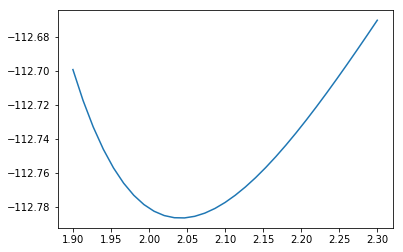

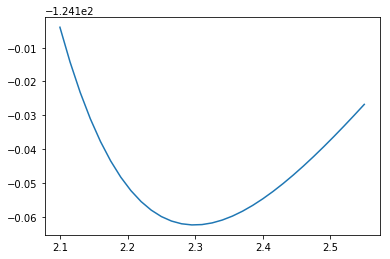

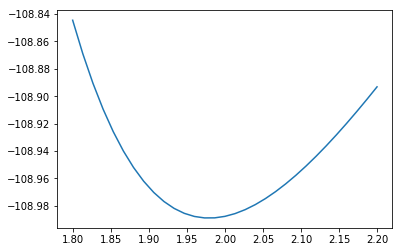

In [82]:
plt.plot(np.linspace(1.9,2.3,31),COscan)
plt.show()
plt.plot(np.linspace(2.1,2.55,31),BFscan)
plt.show()
plt.plot(np.linspace(1.8,2.2,31),NNscan)

In [83]:
def e_scan(mol,np):
    if mol=="CO": return spline(COscanpts,COscan,np)
    if mol=="BF": return spline(BFscanpts,BFscan,np)
    if mol=="NN": return spline(NNscanpts,NNscan,np)

In [84]:
spline(COscanpts,COscan,2.3)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """Entry point for launching an IPython kernel.


array(-112.75844033)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


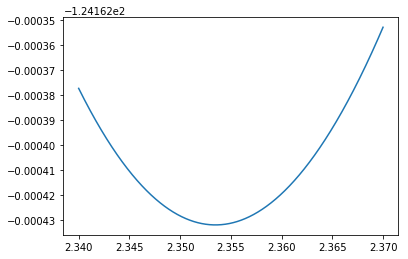

In [44]:
xp=np.linspace(2.34,2.37,1001)
plt.plot(xp,e_scan("BF",xp))

In [49]:
at_en={"B":scf.RHF(gto.M(atom="B 0 0 0",spin=1,basis=pcx2)).scf(),\
       "C":scf.RHF(gto.M(atom="C 0 0 0",basis=pcx2)).scf(),\
       "N":scf.RHF(gto.M(atom="N 0 0 0",spin=1,basis=pcx2)).scf(),\
       "O":scf.RHF(gto.M(atom="O 0 0 0",basis=pcx2)).scf(),\
       "F":scf.RHF(gto.M(atom="F 0 0 0",spin=1,basis=pcx2)).scf()
      }

converged SCF energy = -24.528185922659
converged SCF energy = -37.6029290136078
converged SCF energy = -54.2616567416513
converged SCF energy = -74.6877238559481
converged SCF energy = -99.4065434956606


In [50]:
apbf=APDFT_perturbator(BFhf,sites=[0,1])
apbf.build_all()
apco=APDFT_perturbator(COhf,sites=[0,1])
apco.build_all()
apnn=APDFT_perturbator(NNhf,sites=[0,1])
apnn.build_all()

In [51]:
apco.APDFT3(np.asarray([-1,1]))

-124.12995954395531

In [52]:
bde={"bf":at_en["B"]+at_en["F"]-apco.APDFT3(np.asarray([-1,1])),\
    "co_bf":at_en["C"]+at_en["O"]-apbf.APDFT3(np.asarray([1,-1])),\
    "co_nn":at_en["C"]+at_en["O"]-apnn.APDFT3(np.asarray([-1,1])),\
    "nn":2*at_en["N"]-apco.APDFT3(np.asarray([1,-1]))\
}

In [53]:
bde

{'bf': 0.19523012563566056,
 'co_bf': 0.4527514644502162,
 'co_nn': 0.49129375595914837,
 'nn': 0.4664239499696663}

In [54]:
dl=0.1
c5=get_coeffs(5)
def hoad(mol):
    afs=[]
    hs=[]
    for i in range(-2,3):
        mol1=FcM_like(mol,fcs=[i*dl,-i*dl])
        mf=scf.RHF(mol1)
        mf.scf(dm0=mf.init_guess_by_1e())
        afs.append(aaff(mf,[1,-1])[1,2])
        hs.append(mf.Hessian().hess()[1,1,2,2])
    gders=[afs[2],c5[1].dot(afs)/dl,c5[2].dot(afs)/dl**2,c5[3].dot(afs)/dl**3,c5[4].dot(afs)/dl**4]
    hders=[hs[2],c5[1].dot(hs)/dl,c5[2].dot(hs)/dl**2,c5[3].dot(hs)/dl**3,c5[4].dot(hs)/dl**4]
    return np.asarray(gders),np.asarray(hders)

In [55]:
#gderCO,hderCO=hoad(CO)
#gderBF,hderBF=hoad(BF)
#gderNN,hderNN=hoad(NN)
#np.save("./Diatomics_derivs",np.asarray([gderCO,hderCO,gderBF,hderBF,gderNN,hderNN]))

In [56]:
gderCO=np.load("./Diatomics_derivs.npy")[0]
hderCO=np.load("./Diatomics_derivs.npy")[1]
gderBF=np.load("./Diatomics_derivs.npy")[2]
hderBF=np.load("./Diatomics_derivs.npy")[3]
gderNN=np.load("./Diatomics_derivs.npy")[4]
hderNN=np.load("./Diatomics_derivs.npy")[5]

In [57]:
gpNN=gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+gderCO[4]/120+alc_differential_grad_nuc(CO,[1,-1])[1,2]
hpNN=hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6+hderCO[4]/24

In [58]:
gpco_nn=[gderCO[0]+alc_deriv_grad_nuc(CO,[1,-1])[1,2],
        gderCO[0]+gderCO[1]/2+alc_differential_grad_nuc(CO,[1,-1])[1,2],
         gderCO[0]+gderCO[1]/2+gderCO[2]/6+alc_differential_grad_nuc(CO,[1,-1])[1,2],
        gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+alc_differential_grad_nuc(CO,[1,-1])[1,2],
        gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+gderCO[4]/120+alc_differential_grad_nuc(CO,[1,-1])[1,2]]

In [59]:
hpco_nn=[hderCO[0],
         hderCO[0]+hderCO[1],
         hderCO[0]+hderCO[1]+hderCO[2]/2,
         hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6,
         hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6+hderCO[4]/24]

In [60]:
gpBF=-gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24-gderCO[4]/120+alc_differential_grad_nuc(CO,[-1,1])[1,2]
hpBF=hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6+hderCO[4]/24

In [61]:
gpco_bf=[-gderCO[0]+alc_deriv_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2+alc_differential_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+alc_differential_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24+alc_differential_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24-gderCO[4]/120+alc_differential_grad_nuc(CO,[-1,1])[1,2]]

In [62]:
hpco_bf=[hderCO[0],
         hderCO[0]-hderCO[1],
         hderCO[0]-hderCO[1]+hderCO[2]/2,
         hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6,
         hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6+hderCO[4]/24]

In [63]:
miNN=Morse_interpolator(gpNN,hpNN,co_min[0],bde["nn"]+gpNN**2/hpNN/2,apco.APDFT3(np.asarray([1,-1])))
miNN.minimum(),nn_min,\
co_min[0]-gpNN/hpNN,apco.APDFT3(np.asarray([1,-1]))-gpNN**2/hpNN/2
miBF=Morse_interpolator(gpco_bf[3],hpco_bf[4],co_min[0],bde["bf"]+gpBF**2/hpBF/2,apco.APDFT3(np.asarray([-1,1])))
miBF.minimum(),bf_min,(co_min[0]-gpBF/hpBF,apco.APDFT3(np.asarray([-1,1]))-gpBF**2/hpBF/2,apco.APDFT3(np.asarray([-1,1])))

((2.3408858228081417, -124.15931999267569),
 (2.35348, -124.16243198073053),
 (2.25880033925587, -124.15343476073441, -124.12995954395531))

In [64]:
gpbf_co=[gderBF[0]+alc_deriv_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+alc_differential_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+gderBF[2]/6+alc_differential_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+gderBF[2]/6+gderBF[3]/24+alc_differential_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+gderBF[2]/6+gderBF[3]/24+gderBF[4]/120+alc_differential_grad_nuc(BF,[1,-1])[1,2]]

In [65]:
hpbf_co=[hderBF[0],
         hderBF[0]+hderBF[1],
         hderBF[0]+hderBF[1]+hderBF[2]/2,
         hderBF[0]+hderBF[1]+hderBF[2]/2+hderBF[3]/6,
         hderBF[0]+hderBF[1]+hderBF[2]/2+hderBF[3]/6+hderBF[4]/24]

In [66]:
gpNNco=gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+gderNN[4]/120+alc_differential_grad_nuc(NN,[1,-1])[1,2]
hpNNco=hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6+hderNN[4]/24

In [67]:
gpnn_co=[gderNN[0]+alc_deriv_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+alc_differential_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+gderNN[2]/6+alc_differential_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+alc_differential_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+gderNN[4]/120+alc_differential_grad_nuc(NN,[1,-1])[1,2]]

In [68]:
hpnn_co=[hderNN[0],
         hderNN[0]+hderNN[1],
         hderNN[0]+hderNN[1]+hderNN[2]/2,
         hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6,
         hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6+hderNN[4]/24]

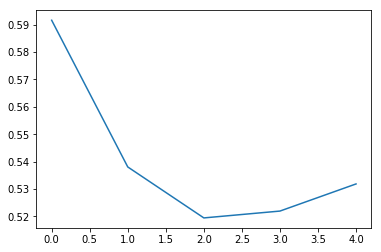

In [69]:
plt.plot(hpbf_co)

In [70]:
miNNco=Morse_interpolator(gpNNco,hpNNco,nn_min[0],bde["co_nn"],apnn.APDFT3(np.asarray([1,-1])))
miNNco.minimum(),co_min

((2.0841766255586096, -112.78602030389315), (2.08272, -112.78661621869807))

In [71]:
mpa(gpNNco,hpNNco,nn_min[0],.49),nn_min[0]-gpNNco/hpNNco,co_min[0]

(2.084187364659855, 2.0760160041655045, 2.08272)

In [72]:
nn_min[1]-2*scf.RHF(gto.M(atom="N 0 0 0",spin=3,basis=pcx2)).scf()

converged SCF energy = -54.3987703681837


-0.1915233389140809

In [73]:
bde

{'bf': 0.19523012563566056,
 'co_bf': 0.4527514644502162,
 'co_nn': 0.49129375595914837,
 'nn': 0.4664239499696663}

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.


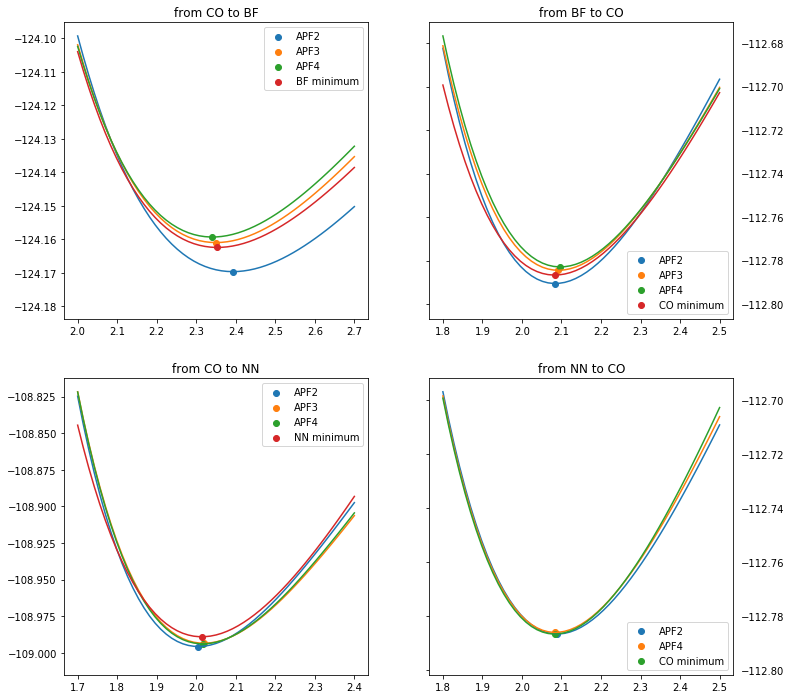

In [151]:
fig, ((ax1, ax2), (ax3, ax4)) =plt.subplots(2,2,figsize=(12,12))
lss=["--",":",]
ax1.set_title("from CO to BF")
scan=np.linspace(2.0,2.7,51)
for i in range(1,4):
    mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"]+gpco_bf[i]**2/2/hpco_bf[i]\
                            ,apco.APDFT3(np.asarray([-1,1])))
    ax1.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax1.plot(scan,mi.E(scan))
ax1.scatter(*bf_min,label="BF minimum")
ax1.plot(scan,e_scan("BF",scan))
ax1.legend()
#############################
ax2.set_title("from BF to CO")
ax2.yaxis.set_tick_params(labelleft=False,labelright=True)
scan=np.linspace(1.8,2.5,51)
for i in range(1,4):
    mi = Morse_interpolator(gpbf_co[i],hpbf_co[i+1],bf_min[0],bde["co_bf"]+gpbf_co[i]**2/2/hpbf_co[i],apbf.APDFT3(np.asarray([1,-1])))
    ax2.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax2.plot(scan,mi.E(scan))
ax2.scatter(*co_min,label="CO minimum")
ax2.plot(scan,e_scan("CO",scan))
ax2.legend() 
###############################
ax3.set_title("from CO to NN")
scan=np.linspace(1.7,2.4,51)
for i in range(1,4):
    mi = Morse_interpolator(gpco_nn[i],hpco_nn[i+1],co_min[0],bde["nn"]+gpco_nn[i]**2/2/hpco_nn[i],apco.APDFT3(np.asarray([1,-1])))
    ax3.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax3.plot(scan,mi.E(scan))
ax3.scatter(*nn_min,label="NN minimum")
ax3.plot(scan,e_scan("NN",scan))
ax3.legend() 
##############################
ax4.set_title("from NN to CO")
ax4.yaxis.set_tick_params(labelleft=False,labelright=True)
scan=np.linspace(1.8,2.5,51)
for i in [1,3]:
    mi = Morse_interpolator(gpnn_co[i],hpnn_co[i+1],nn_min[0],bde["co_nn"]+gpnn_co[i]**2/2/hpnn_co[i],apnn.APDFT3(np.asarray([-1,1])))
    ax4.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax4.plot(scan,mi.E(scan))
ax4.scatter(*co_min,label="CO minimum")
ax4.plot(scan,e_scan("CO",scan))
ax4.legend() 